In [1]:
import os
import time
from tqdm import tqdm

import clip
import torch
from torch import nn
import torchvision
import numpy as np
from PIL import Image
import numpy as np
import kornia.augmentation as K
import kornia
import kornia.enhance as Ke
from typing import List, Optional
from torch.utils.data import Dataset, DataLoader

# Seeding
torch.manual_seed(42)
torch.cuda.manual_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
_, preprocess = clip.load("ViT-B/32", device="cpu")

In [6]:
from matplotlib import pyplot as plt
import torchvision.transforms.functional as TF


def plot_images(images):
    cols = 8
    rows = (images.shape[0] + cols - 1) // cols

    plt.figure(figsize=(cols * 2, rows * 2))
    for i in range(images.shape[0]):
        img = images[i]
        img = TF.to_pil_image(img)  # Convert from [C, H, W] to PIL image

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

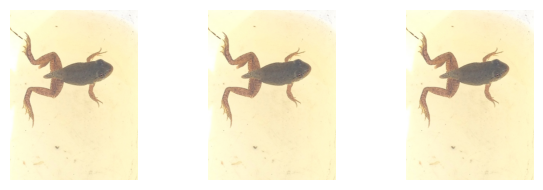

In [7]:
image = torchvision.io.read_image(
    "datasets/imagenet-a/n01641577/0.038738_agama _ newt_0.7465035.jpg"
)

images = image.float().div(255).repeat(3, 1, 1, 1)
plot_images(images)

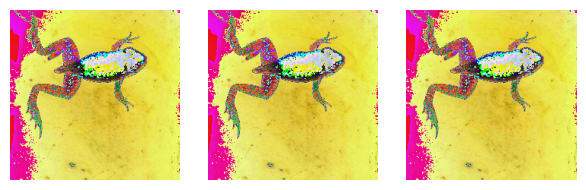

In [7]:
# tensor image to PIL
pil_image = torchvision.transforms.functional.to_pil_image(image)

preprocesses_image = preprocess(pil_image)

plot_images(preprocesses_image.repeat(3, 1, 1, 1))

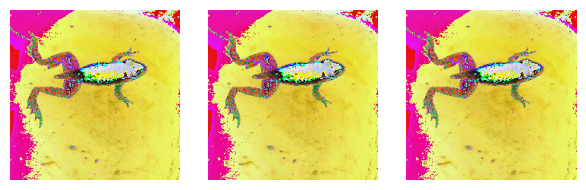

In [8]:
# do the same with Kornia

import kornia.augmentation as K
import torch.nn as nn
import kornia

model_transform = nn.Sequential(
    K.Resize(size=(224, 224), align_corners=False, antialias=True),
    K.CenterCrop(size=(224, 224)),
    kornia.enhance.Normalize(
        mean=torch.tensor([0.48145466, 0.4578275, 0.40821073]),
        std=torch.tensor([0.26862954, 0.26130258, 0.27577711]),
    ),
)

kornia_preprocessed = model_transform(image.float().div(255).unsqueeze(0))
plot_images(kornia_preprocessed.repeat(3, 1, 1, 1))

# Augmix


In [10]:
augmix = torchvision.transforms.AugMix()

transform = torchvision.transforms.Compose([augmix, preprocess])

n_times = 20

import time

start = time.time()
for i in range(n_times):
    transformed = [transform(pil_image) for _ in range(63)]
end = time.time()
print(f"Latency per image: {(end - start) / n_times *1000:.4f} ms")

Latency per image: 946.9336 ms


In [ ]:
from typing import List, Optional

class AugMixKornia:
    def __init__(
        self,
        severity: int = 3,
        width: int = 3,
        depth: int = -1,
        alpha: float = 1.0,
        mixture_width: int = 3,
        chain_depth: int = 3,
        all_ops: bool = True,
        device: Optional[str] = None,
    ):
        """
        AugMix implementation using Kornia with closer fidelity to the original paper.

        Args:
            severity: Severity level of augmentations (1-10)
            width: Width of augmentation chain (not used directly, kept for compatibility)
            depth: Depth of augmentation chain (-1 for random between 1-3)
            alpha: Dirichlet distribution parameter for mixing weights
            mixture_width: Number of augmentation chains to mix
            chain_depth: Number of operations in each chain
            all_ops: Whether to use all augmentation operations
            device: Device to run on (cuda/cpu)
        """
        self.severity = severity
        self.alpha = alpha
        self.mixture_width = mixture_width
        self.chain_depth = chain_depth if depth <= 0 else depth
        self.all_ops = all_ops
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")

        # Define augmentation operations
        self.augmentations = self._get_augmentations()

    def _get_augmentations(self) -> List[nn.Module]:
        """Create a list of augmentation operations that will be randomly applied"""
        severity_factor = self.severity / 10.0

        if self.all_ops:
            # Full set of augmentations similar to original AugMix
            return [
                # AutoContrast
                K.ColorJitter(
                    brightness=0.1 * self.severity, contrast=0.1 * self.severity, p=1.0
                ),
                # Equalize
                Ke.equalize,
                # Posterize
                K.RandomPosterize(bits=max(1, 8 - self.severity), p=1.0),
                # Rotate
                K.RandomRotation(
                    degrees=(-30 * severity_factor, 30 * severity_factor), p=1.0
                ),
                # Solarize
                K.RandomSolarize(
                    thresholds=0.5, additions=(0.0, 0.1 * self.severity), p=1.0
                ),
                # Shear
                K.RandomAffine(
                    degrees=0,
                    shear=(-15 * severity_factor, 15 * severity_factor),
                    p=1.0,
                ),
                # Translate
                K.RandomAffine(
                    degrees=0,
                    translate=(0.1 * severity_factor, 0.1 * severity_factor),
                    p=1.0,
                ),
                # ColorJitter
                K.ColorJitter(
                    brightness=0.1 * self.severity,
                    contrast=0.1 * self.severity,
                    saturation=0.1 * self.severity,
                    hue=0.1,
                    p=1.0,
                ),
            ]
        else:
            # Simplified version
            return [
                K.ColorJitter(
                    brightness=0.1 * self.severity, contrast=0.1 * self.severity, p=1.0
                ),
                Ke.equalize,
                K.RandomAffine(
                    degrees=(-15 * severity_factor, 15 * severity_factor), p=1.0
                ),
            ]

    def _apply_augmentation_chain(self, image: torch.Tensor) -> torch.Tensor:
        """
        Apply a random sequence of augmentations to an image.

        Args:
            image: Input image tensor (C, H, W)

        Returns:
            Augmented image tensor (C, H, W)
        """
        # Randomly select augmentations for this chain
        op_indices = np.random.choice(
            len(self.augmentations), size=self.chain_depth, replace=True
        )

        # Apply augmentations in random order
        # augmented = image.clone()
        # for op_idx in op_indices:
        # op = self.augmentations[op_idx]
        # augmented = op(augmented.unsqueeze(0)).squeeze(0)

        augmented = image  # Don't clone immediately
        for op_idx in op_indices:
            augmented = self.augmentations[op_idx](augmented)

        return augmented.squeeze(0)

    def __call__(self, images: torch.Tensor) -> torch.Tensor:
        """
        Apply AugMix to a batch of images.

        Args:
            images: Input batch of images (B, C, H, W) or (C, H, W)

        Returns:
            Augmented batch (same shape as input)
        """
        # Input validation
        if not isinstance(images, torch.Tensor):
            images = K.image_to_tensor(images)

        if images.dim() == 3:
            images = images.unsqueeze(0)

        # Move to device if needed
        if images.device != self.device:
            images = images.to(self.device)

        batch_size = images.shape[0]

        # Sample mixing weights from Dirichlet distribution
        weights = (
            torch.from_numpy(
                np.random.dirichlet([self.alpha] * self.mixture_width, size=batch_size)
            )
            .float()
            .to(self.device)
        )  # Shape (B, mixture_width)

        # Sample weights for mixing with original
        mix_weights = (
            torch.from_numpy(
                np.random.dirichlet([self.alpha, self.alpha], size=batch_size)
            )
            .float()
            .to(self.device)
        )  # Shape (B, 2)

        # Generate augmented versions for each mixture component
        # Pre-allocate memory for augmented versions
        augmented = torch.empty(
            (self.mixture_width, batch_size, *images.shape[1:]), device=self.device
        )

        for i in range(self.mixture_width):
            augmented[i] = self._apply_augmentation_chain(images)

        # augmented = torch.stack(augmented).to(self.device)

        # Weighted sum of augmented versions
        mixed = torch.einsum("mbchw,bm->bchw", augmented, weights).to(self.device)

        # Final mix with original image
        result = (
            mix_weights[:, 0:1, None, None] * images
            + mix_weights[:, 1:2, None, None] * mixed
        )

        return result.squeeze(0) if result.shape[0] == 1 else result


model_transform = nn.Sequential(
    K.Resize(size=(224, 224), align_corners=False, antialias=True),
    K.CenterCrop(size=(224, 224)),
    kornia.enhance.Normalize(
        mean=torch.tensor([0.48145466, 0.4578275, 0.40821073]),
        std=torch.tensor([0.26862954, 0.26130258, 0.27577711]),
    ),
)


my_augmix = AugMixKornia()

n_times = 20

start = time.time()
for i in range(n_times):
    images = image.float().div(255).repeat(63, 1, 1, 1)
    views = my_augmix(images)
end = time.time()
print(f"Latency per image: {(end - start) / n_times *1000:.4f} ms")

Latency per image: 440.6941 ms
